In [66]:
import numpy as np 
import pandas as pd 
import scipy.io
import matplotlib.pyplot as plt 
import stackprinter 
import prettytable as pt

In [4]:
stackprinter.set_excepthook(style='darkbg2')

# 1 Gaussian Process for Regression

## 匯入資料

In [38]:
data = scipy.io.loadmat('/Users/tommy84729/python/ML_HW3/gp.mat')
train = data['x'][ : 60].reshape(-1)
train_t = data['t'][ : 60].reshape(-1)
test = data['x'][60 : ].reshape(-1)
test_t = data['t'][60: ].reshape(-1)

## 1.1  exponential-quadratic kernel function

kernel : $$ k({\mathrm X}_n,\ {\mathrm X}_m) = \theta_0\exp\left\{ -\frac{\theta_1}{2}||{\mathrm X}_n-{\mathrm X}_m||^2\right\} + \theta_2 + \theta_3 {\mathrm X}_n^T{\mathrm X}_m$$ 

In [39]:
def kernel(theta, xn, xm) :
    kernel = theta[0] * np.exp(-0.5*theta[1]*np.subtract.outer(xn, xm)**2) + theta[2] + theta[3] * np.multiply.outer(xn, xm)
    return kernel 

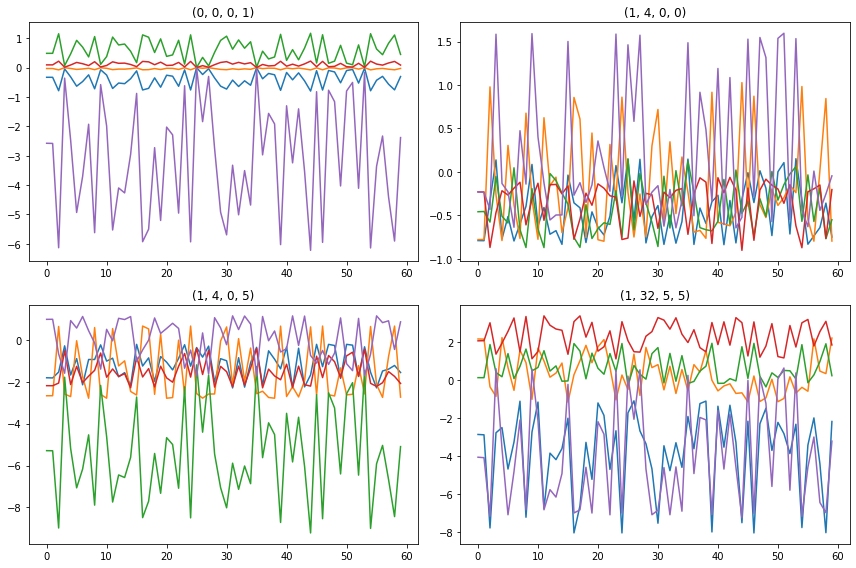

In [40]:
hype = [[0,0,0,1], [1,4,0,0], [1,4,0,5], [1,32,5,5]]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
e = np.zeros_like(train).reshape(-1)
ax = axes.ravel()
for ax, theta in zip(ax, hype) : 
    ker = kernel(theta, train, train).reshape(-1, 60)
    ax.plot(np.random.multivariate_normal(e, ker, size=5).T)
    ax.set_title(f"({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})")
plt.tight_layout()
    
    

## 1.2 Plot the prediction result for training set with one standard deviation. The red line shows the mean m(·) of the GP predictive distributioin

In [43]:
def gp_reg(train, train_target, theta, data) : 
    beta_inv = 1
    cn = kernel(theta, train, train)+ beta_inv*np.eye(len(train)).reshape(-1,60)
    mean = np.empty(len(data))
    std = np.empty(len(data))
    
    for i in range(len(data)) : 
        k = kernel(theta, train, data[i])
        mean[i] = np.linalg.multi_dot([k.T, np.linalg.inv(cn), train_target])
        c = kernel(theta, data[i], data[i])+beta_inv
        std[i] = np.sqrt(c - np.linalg.multi_dot([k.T, np.linalg.inv(cn), k]))
                   
    return mean, std

In [45]:
gp_reg(train, train_t, hype[0],np.linspace(0, 2, 300))

(300,)

### Plot predictive distribution 

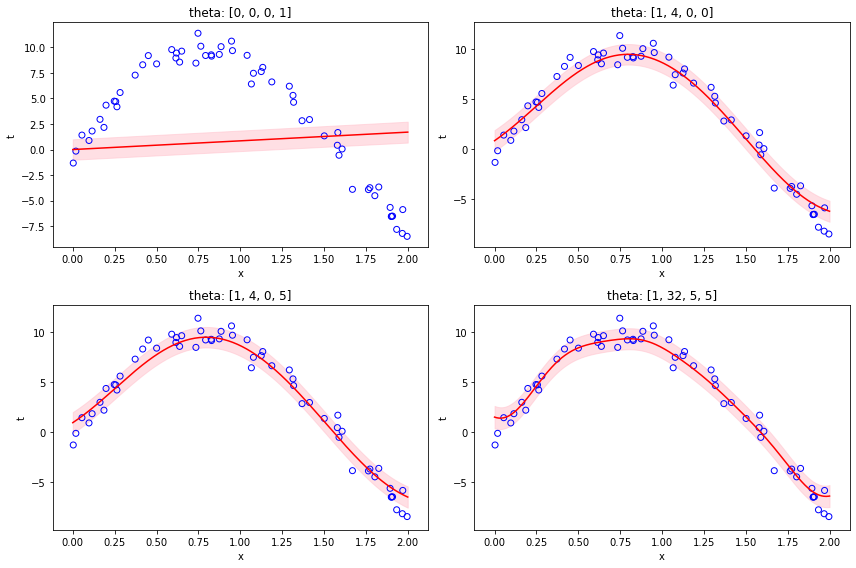

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_pos = {0:(0, 0), 1:(0, 1), 2:(1, 0), 3:(1, 1)}
train_rmse = list()
test_rmse = list()
for i, theta in enumerate(hype) : 
    data = np.linspace(0, 2, 300)
    mean, std = gp_reg(train, train_t, theta, data)
    mean_train, _ = gp_reg(train, train_t, theta, train)
    mean_test, _ = gp_reg(train, train_t, theta, test)
    pos = plot_pos[i]
    axes[pos].set_title('theta: '+str(theta))
    axes[pos].plot(data, mean, 'r-')
    axes[pos].fill_between(data, mean+std, mean-std, color='pink', alpha=0.5)
    axes[pos].scatter(train, train_t, facecolors='none', edgecolors='b')
    axes[pos].set_xlabel('x')
    axes[pos].set_ylabel('t')
    tra_rmse = np.sqrt(np.mean((mean_train - train_t)**2))
    te_rmse = np.sqrt(np.mean((mean_test - test_t)**2))
    train_rmse.append(tra_rmse)
    test_rmse.append(te_rmse)
plt.tight_layout()

## 1.3 Calculate the corresponding root-mean-square errors

In [67]:
tb = pt.PrettyTable()
tb.add_column('Theta', hype)
tb.add_column('Train_rmse', train_rmse)
tb.add_column('Test_rmse', test_rmse)
print(tb)

+---------------+--------------------+--------------------+
|     Theta     |     Train_rmse     |     Test_rmse      |
+---------------+--------------------+--------------------+
|  [0, 0, 0, 1] | 6.657589544465415  | 6.748539094668654  |
|  [1, 4, 0, 0] | 1.0522430749915168 | 1.2987957582217349 |
|  [1, 4, 0, 5] | 1.0288404038224808 | 1.2860902332963635 |
| [1, 32, 5, 5] | 0.9640449236945069 | 1.2584685192274416 |
+---------------+--------------------+--------------------+
